# Programming Exercise 4: Neural Networks Learning

# 1 Neural Networks

In [18]:
# Make y back to normal. (10 -> 0)
import numpy as np
from scipy.io import loadmat

K = 10

def toggle(y):
    if len(y.shape) == 1:
        yt = np.zeros((y.shape[0], K))
        yt[range(len(y)), y] = 1
        return yt
    else:
        return np.argmax(y, axis=1)

mat = loadmat('data/ex4data1.mat')
X = mat['X']
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

y = mat['y'][:, 0]

y = np.array(list(map(lambda x: 0 if x == 10 else x, y)))
y = toggle(y) # toggle y

X.shape, y.shape

((5000, 401), (5000, 10))

# 1.1 Visualizing the data

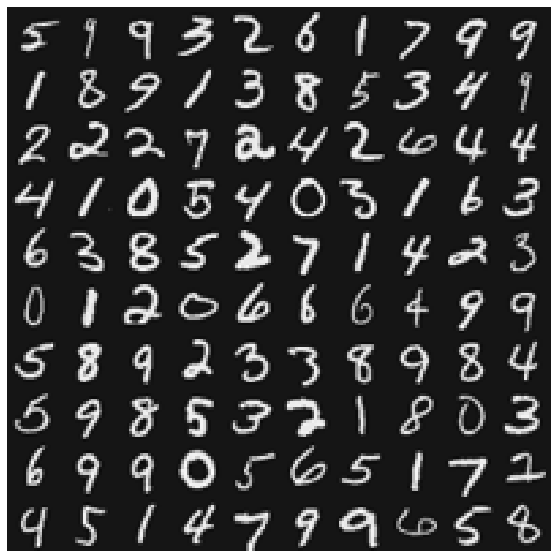

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_numbers(src):
    """输入的 src 的 shape[0] 必须是平方数"""
    size = round(src.shape[0] ** 0.5)
    data = np.zeros((20 * size, 20 * size))
    def modify(i, j):
        data[20 * i: 20 * (i + 1), 20 * j: 20 * (j + 1)] = src[i * size + j, :].reshape((20, 20)).T
    [modify(i, j) for i in range(size) for j in range(size)]

    fig = plt.figure(figsize=(size, size))
    ax = fig.gca()
    ax.matshow(data, cmap='gray')

    plt.axis('off')
    plt.show()

plot_numbers(X[np.random.randint(low=0, high=5000 + 1, size=100), 1:])

# 1.2 Model representation

In [20]:
mat = loadmat('data/ex4weights.mat')
theta1 = mat['Theta1']
theta2 = mat['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

# 1.3 Feedforward and cost function
这个 cost_function 算不准没有关系，因为老师用的是 1-10 训练出来的，我用的是 0-9

In [21]:
from operator import mul

def sigmoid(z):
    return 1 / (1 + np.e ** (-z))

def hypothesis_nn(theta_one, theta_two, z):
    a1 = z
    a2 = sigmoid(np.concatenate((np.ones((a1.shape[0], 1)), a1 @ theta_one.T), axis=1))
    return sigmoid(a2 @ theta_two.T)

def flatten(t):
    if type(t) is tuple:
        return np.concatenate([t[0].flatten(), t[1].flatten()])
    else:
        return t[:mul(*theta1.shape)].reshape(theta1.shape), t[mul(*theta1.shape): mul(*theta1.shape) + mul(*theta2.shape)].reshape(theta2.shape)

def cost_function_nn(theta, X, y):
    theta_one, theta_two = flatten(theta)
    return (-y * np.log(hypothesis_nn(theta_one, theta_two, X)) - (1 - y) * np.log(1 - hypothesis_nn(theta_one, theta_two, X))).sum(axis=1).mean()


theta = flatten((theta1, theta2))
cost_function_nn(theta, X, y)

10.44497478777614

# 1.4 Regularized cost function

In [22]:
def cost_function_nn_reg(theta, X, y, lam):
    m = y.shape[0]
    theta_one, theta_two = flatten(theta)
    return cost_function_nn(theta, X, y) + lam / 2 / m * ((theta_one[:, 1:] ** 2).sum() + (theta_two[:, 1:] ** 2).sum())

cost_function_nn_reg(theta, X, y, 1)

10.541115481705745

# 2 Backpropagation

# 2.1 Sigmoid gradient

In [23]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

sigmoid_gradient(0)

0.25

# 2.2 Random initialization

In [24]:
epsilon_init = 0.12
theta_one = np.random.uniform(-epsilon_init, epsilon_init, size=theta1.shape)
theta_two = np.random.uniform(-epsilon_init, epsilon_init, size=theta2.shape)
theta = flatten((theta_one, theta_two))

theta_one.shape, theta_two.shape, theta.shape

((25, 401), (10, 26), (10285,))

# 2.3 Backpropagation

In [25]:
def gradient_nn(theta, X, y):
    m = y.shape[0]

    theta_one, theta_two = flatten(theta)

    a1 = X
    z2 = np.concatenate((np.ones((a1.shape[0], 1)), a1 @ theta_one.T), axis=1)
    a2 = sigmoid(z2)
    z3 = a2 @ theta_two.T
    a3 = sigmoid(z3)

    delta3 = a3 - y
    delta2 = delta3 @ theta_two * sigmoid_gradient(z2)

    Delta2 = (a2[:, :, None] @ delta3[:, None, :]).sum(axis=0).T
    Delta1 = (a1[:, :, None] @ delta2[:, None, 1:]).sum(axis=0).T

    D1 = Delta1 / m
    D2 = Delta2 / m

    return flatten((D1, D2))

gradient_nn(theta, X, y)[:10]

array([ 5.41162749e-03,  0.00000000e+00,  0.00000000e+00,  1.62534958e-09,
       -2.07410480e-08, -4.02238621e-08,  1.37107161e-06,  2.03305057e-06,
        1.14599003e-06,  8.89438419e-08])

# 2.4 Gradient checking

In [26]:
epsilon = 10e-4

gradient_nn_numeric = []

for i in range(len(theta))[:10]:
    err = np.zeros_like(theta)
    err[i] = epsilon
    theta_pos = theta + err
    theta_neg = theta - err
    gradient_nn_numeric.append((cost_function_nn(theta_pos, X, y) - cost_function_nn(theta_neg, X, y)) / 2 / epsilon)

gradient_nn_numeric = np.array(gradient_nn_numeric)
gradient_nn_numeric[:10] # 几乎一模一样，说明计算正确

array([ 5.41162706e-03,  0.00000000e+00,  0.00000000e+00,  1.62536651e-09,
       -2.07407425e-08, -4.02233802e-08,  1.37107170e-06,  2.03305062e-06,
        1.14598953e-06,  8.89439633e-08])

# 2.5 Regularized Neural Networks

In [27]:
def gradient_nn_reg(theta, X, y, lam):
    m = y.shape[0]
    D1, D2 = flatten(gradient_nn(theta, X, y))
    theta_one, theta_two = flatten(theta)
    
    D2[1:, :] = D2[1:, :] + lam / m * theta_two[1:, :]
    D1[1:, :] = D1[1:, :] + lam / m * theta_one[1:, :]

    return flatten((D1, D2))

gradient_nn_reg(theta, X, y, 1)[:10]

array([ 5.41162749e-03,  0.00000000e+00,  0.00000000e+00,  1.62534958e-09,
       -2.07410480e-08, -4.02238621e-08,  1.37107161e-06,  2.03305057e-06,
        1.14599003e-06,  8.89438419e-08])

# 2.6 Learning parameters using fmincg
用 scipy.optimize.minimize 学了两个小时也学不出结果，不如换一个 fmin_cg，几分钟就学出来了，非常适合多参数学习。而且准确率相当高了，已经怕是过拟合了

         Current function value: 0.357242
         Iterations: 141
         Function evaluations: 431
         Gradient evaluations: 419


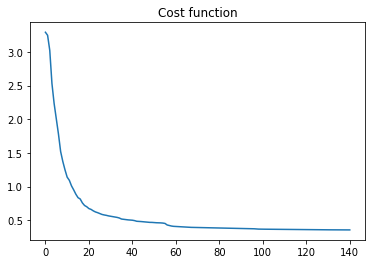

In [28]:
from scipy.optimize import minimize
from scipy.optimize import fmin_cg

LAM = 1

def learning(X, y):
    costs = []
    def cb(theta):
        costs.append(cost_function_nn_reg(theta, X, y, LAM))
    result = fmin_cg(cost_function_nn_reg, theta, gradient_nn_reg, (X, y, LAM), callback=cb)
    plt.plot(costs)
    plt.title('Cost function')
    plt.show()
    return result

theta_opt = learning(X, y)

In [29]:
(toggle(hypothesis_nn(*flatten(theta_opt), X)) == toggle(y)).sum() / y.shape[0]

0.9894

# 3 Visualizing the hidden layer

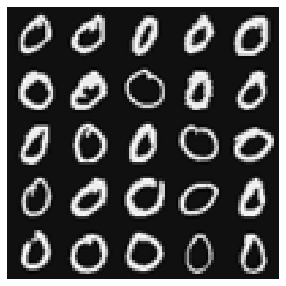

In [30]:
plot_numbers(X[:25, 1:])

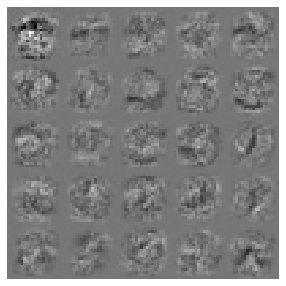

In [31]:
hidden = flatten(theta_opt)[0][:, 1:]
plot_numbers(hidden)

         Current function value: 0.079041
         Iterations: 262
         Function evaluations: 842
         Gradient evaluations: 831


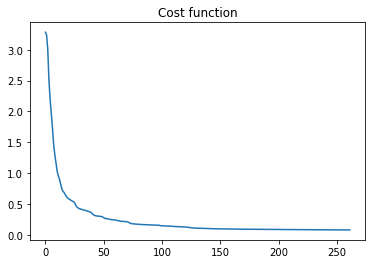

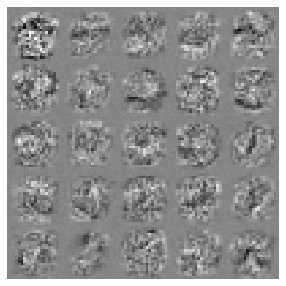

In [32]:
LAM = 0.1
theta_opt2 = learning(X, y)
plot_numbers(flatten(theta_opt2)[0][:, 1:])

         Current function value: 0.236636
         Iterations: 197
         Function evaluations: 576
         Gradient evaluations: 564


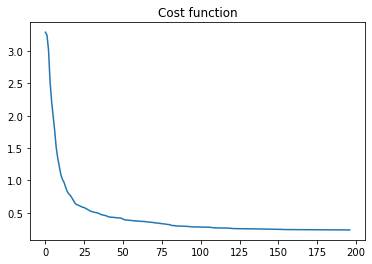

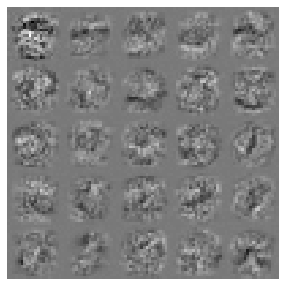

In [33]:
LAM = 0.5
theta_opt3 = learning(X, y)
plot_numbers(flatten(theta_opt3)[0][:, 1:])

In [34]:
LAM = 1